In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

In [20]:
# Path to your dataset directory
sdir = r'D:\manda\Data coba'

filepaths = []
labels = []

classlist = os.listdir(sdir)

for klass in classlist:
    classpath = os.path.join(sdir, klass)

    if os.path.isdir(classpath):
        for parameter in ['buah', 'biji', 'daun']:
            param_path = os.path.join(classpath, parameter)
            param_files = os.listdir(param_path)

            for f in param_files:
                fpath = os.path.join(param_path, f)
                filepaths.append(fpath)
                labels.append(klass)

# Create a DataFrame to store file paths and labels
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

print(df.head())
print(df['labels'].value_counts())


                                           filepaths   labels
0  D:\manda\Data coba\arabika\buah\10_jpg.rf.5e4d...  arabika
1  D:\manda\Data coba\arabika\buah\10_jpg.rf.e9f2...  arabika
2  D:\manda\Data coba\arabika\buah\11_jpg.rf.097c...  arabika
3  D:\manda\Data coba\arabika\buah\11_jpg.rf.1ac0...  arabika
4  D:\manda\Data coba\arabika\buah\11_jpg.rf.fe17...  arabika
labels
arabika    307
robusta    182
Name: count, dtype: int64


In [21]:
import os
import shutil
import random

# Define path to original data directory
data_dir = r'D:\manda\Data coba'

# Define path to directories for train, test, and validation data
train_dir = r'D:\manda\Data coba\train'
test_dir = r'D:\manda\Data coba\test'
val_dir = r'D:\manda\Data coba\validation'

# Define labels (arabika and robusta) and parameters (buah, biji, daun)
labels = ["arabika", "robusta"]
parameters = ["buah", "biji", "daun"]

# Set the percentage of images to be used for validation
val_ratio = 0.1  # 10% for validation
test_ratio = 0.1  # 10% for testing
train_ratio = 1 - (val_ratio + test_ratio)  # 80% for training

# Create the train, test, and validation directories if they don't exist
for label in labels:
    for parameter in parameters:
        train_label_dir = os.path.join(train_dir, label, parameter)
        test_label_dir = os.path.join(test_dir, label, parameter)
        val_label_dir = os.path.join(val_dir, label, parameter)
        
        os.makedirs(train_label_dir, exist_ok=True)
        os.makedirs(test_label_dir, exist_ok=True)
        os.makedirs(val_label_dir, exist_ok=True)

# Loop through each label and parameter
for label in labels:
    for parameter in parameters:
        # Define the path to the original data directory for the current label and parameter
        data_label_parameter_dir = os.path.join(data_dir, label, parameter)
        
        # Get the list of image filenames in the data directory
        img_filenames = os.listdir(data_label_parameter_dir)
        
        # Shuffle the list of filenames
        random.shuffle(img_filenames)
        
        # Calculate the number of images to use for validation and testing
        num_val = int(len(img_filenames) * val_ratio)
        num_test = int(len(img_filenames) * test_ratio)
        
        # Copy images for validation
        for filename in img_filenames[:num_val]:
            src = os.path.join(data_label_parameter_dir, filename)
            dst = os.path.join(val_dir, label, parameter, filename)
            shutil.copyfile(src, dst)
        
        # Copy images for testing
        for filename in img_filenames[num_val:num_val + num_test]:
            src = os.path.join(data_label_parameter_dir, filename)
            dst = os.path.join(test_dir, label, parameter, filename)
            shutil.copyfile(src, dst)
        
        # Copy the remaining images for training
        for filename in img_filenames[num_val + num_test:]:
            src = os.path.join(data_label_parameter_dir, filename)
            dst = os.path.join(train_dir, label, parameter, filename)
            shutil.copyfile(src, dst)


In [22]:
len(filepaths)

489

In [23]:
# Hitung jumlah gambar dalam masing-masing direktori
num_train_images = sum([len(files) for root, dirs, files in os.walk(train_dir)])
num_test_images = sum([len(files) for root, dirs, files in os.walk(test_dir)])
num_val_images = sum([len(files) for root, dirs, files in os.walk(val_dir)])

# Cetak panjang masing-masing data frame
print('train length:', num_train_images, '  test length:', num_test_images, '  valid length:', num_val_images)

train_df length: 397   test_df length: 46   valid_df length: 46


In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os

# Define augmentasi data
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotasi acak hingga 20 derajat
    width_shift_range=0.2,  # Geser lebar acak hingga 20% dari lebar gambar
    height_shift_range=0.2,  # Geser tinggi acak hingga 20% dari tinggi gambar
    shear_range=0.2,  # Pencabangan acak
    zoom_range=0.2,  # Perbesaran acak
    horizontal_flip=True,  # Putar horizontal acak
    fill_mode='nearest'  # Isi gambar yang terpotong
)

# Set the base directory for data sekunder
base_dir = 'D:/manda/Data coba/'

# Define labels (arabika and robusta) and parameters (buah, biji, daun)
labels = ["arabika", "robusta"]
parameters = ["buah", "biji", "daun"]

# Define file extensions to consider for augmentation (e.g., "jpg", "jpeg", "png", etc.)
file_extensions = ["jpg", "jpeg", "png"]

# Loop through each label, parameter, and file extension
for label in labels:
    for parameter in parameters:
        for extension in file_extensions:
            # Define the directory containing the images to be augmented
            data_dir = os.path.join(base_dir, 'test', label, parameter)
            
            # Create the directory for augmented images if it doesn't exist
            augmented_test_dir = os.path.join(base_dir, 'test', 'augmented', label, parameter)
            os.makedirs(augmented_test_dir, exist_ok=True)
            
            # Get a list of all the image filenames with the specified extension
            image_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.lower().endswith(f".{extension}")]
            
            # Generate augmented images and save them to the directory
            for image_path in image_files:
                # Load the image
                image = load_img(image_path)
                
                # Reshape the image to a 3D array (height, width, channels)
                x = img_to_array(image)
                x = x.reshape((1,) + x.shape)
                
                # Generate augmented images and save them to the directory
                i = 0
                for batch in datagen.flow(x, batch_size=1, save_to_dir=augmented_test_dir,
                                           save_prefix='aug', save_format='png'):
                    i += 1
                    if i >= 10:  # Generate 10 augmented images per original image
                        break


In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os

# Define augmentasi data
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotasi acak hingga 20 derajat
    width_shift_range=0.2,  # Geser lebar acak hingga 20% dari lebar gambar
    height_shift_range=0.2,  # Geser tinggi acak hingga 20% dari tinggi gambar
    shear_range=0.2,  # Pencabangan acak
    zoom_range=0.2,  # Perbesaran acak
    horizontal_flip=True,  # Putar horizontal acak
    fill_mode='nearest'  # Isi gambar yang terpotong
)

# Set the base directory for data sekunder
base_dir = 'D:/manda/Data coba/'

# Define labels (arabika and robusta) and parameters (buah, biji, daun)
labels = ["arabika", "robusta"]
parameters = ["buah", "biji", "daun"]

# Define file extensions to consider for augmentation (e.g., "jpg", "jpeg", "png", etc.)
file_extensions = ["jpg", "jpeg", "png"]

# Loop through each label, parameter, and file extension
for label in labels:
    for parameter in parameters:
        for extension in file_extensions:
            # Define the directory containing the images to be augmented
            data_dir = os.path.join(base_dir, 'validation', label, parameter)
            
            # Create the directory for augmented images if it doesn't exist
            augmented_val_dir = os.path.join(base_dir, 'validation', 'augmented', label, parameter)
            os.makedirs(augmented_val_dir, exist_ok=True)
            
            # Get a list of all the image filenames with the specified extension
            image_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.lower().endswith(f".{extension}")]
            
            # Generate augmented images and save them to the directory
            for image_path in image_files:
                # Load the image
                image = load_img(image_path)
                
                # Reshape the image to a 3D array (height, width, channels)
                x = img_to_array(image)
                x = x.reshape((1,) + x.shape)
                
                # Generate augmented images and save them to the directory
                i = 0
                for batch in datagen.flow(x, batch_size=1, save_to_dir=augmented_val_dir,
                                           save_prefix='aug', save_format='png'):
                    i += 1
                    if i >= 10:  # Generate 10 augmented images per original image
                        break


In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os

# Define augmentasi data
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotasi acak hingga 20 derajat
    width_shift_range=0.2,  # Geser lebar acak hingga 20% dari lebar gambar
    height_shift_range=0.2,  # Geser tinggi acak hingga 20% dari tinggi gambar
    shear_range=0.2,  # Pencabangan acak
    zoom_range=0.2,  # Perbesaran acak
    horizontal_flip=True,  # Putar horizontal acak
    fill_mode='nearest'  # Isi gambar yang terpotong
)

# Set the base directory for data sekunder
base_dir = 'D:/manda/Data coba/'

# Define labels (arabika and robusta) and parameters (buah, biji, daun)
labels = ["arabika", "robusta"]
parameters = ["buah", "biji", "daun"]

# Define file extensions to consider for augmentation (e.g., "jpg", "jpeg", "png", etc.)
file_extensions = ["jpg", "jpeg", "png"]

# Loop through each label, parameter, and file extension
for label in labels:
    for parameter in parameters:
        for extension in file_extensions:
            # Define the directory containing the images to be augmented
            data_dir = os.path.join(base_dir, 'train', label, parameter)
            
            # Create the directory for augmented images if it doesn't exist
            augmented_train_dir = os.path.join(base_dir, 'train', 'augmented', label, parameter)
            os.makedirs(augmented_train_dir, exist_ok=True)
            
            # Get a list of all the image filenames with the specified extension
            image_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.lower().endswith(f".{extension}")]
            
            # Generate augmented images and save them to the directory
            for image_path in image_files:
                # Load the image
                image = load_img(image_path)
                
                # Reshape the image to a 3D array (height, width, channels)
                x = img_to_array(image)
                x = x.reshape((1,) + x.shape)
                
                # Generate augmented images and save them to the directory
                i = 0
                for batch in datagen.flow(x, batch_size=1, save_to_dir=augmented_train_dir,
                                           save_prefix='aug', save_format='png'):
                    i += 1
                    if i >= 10:  # Generate 10 augmented images per original image
                        break


In [29]:
import os

# Tentukan path ke direktori augmented
augmented_test_dir = 'D:/manda/Data coba/test/augmented'
augmented_train_dir = 'D:/manda/Data coba/train/augmented'
augmented_val_dir = 'D:/manda/Data coba/validation/augmented'

# Hitung jumlah gambar dalam masing-masing direktori
total_test_images = sum([len(files) for subdir, dirs, files in os.walk(augmented_test_dir)])
total_train_images = sum([len(files) for subdir, dirs, files in os.walk(augmented_train_dir)])
total_val_images = sum([len(files) for subdir, dirs, files in os.walk(augmented_val_dir)])

# Cetak hasil
print("Total gambar dalam direktori augmented test:", total_test_images)
print("Total gambar dalam direktori augmented train:", total_train_images)
print("Total gambar dalam direktori augmented validation:", total_val_images)


Total gambar dalam direktori augmented test: 458
Total gambar dalam direktori augmented train: 3730
Total gambar dalam direktori augmented validation: 455


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Define augmentasi data
# datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,  # Rotasi acak hingga 20 derajat
#     width_shift_range=0.2,  # Geser lebar acak hingga 20% dari lebar gambar
#     height_shift_range=0.2,  # Geser tinggi acak hingga 20% dari tinggi gambar
#     shear_range=0.2,  # Pencabangan acak
#     zoom_range=0.2,  # Perbesaran acak
#     horizontal_flip=True,  # Putar horizontal acak
#     fill_mode='nearest'  # Isi gambar yang terpotong
# )

# Set the base directory for data sekunder
base_dir = 'D:/manda/Data coba/'

# Define batch size and image dimensions
height = 224
width = 224
channels = 3
batch_size = 64
img_shape = (height, width, channels)
img_size = (height, width)

length =total_test_images
test_batch_size = sorted([int(length / n) for n in range(1, length + 1) if length % n == 0 and length / n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)
print('test batch size:', test_batch_size, '  test steps:', test_steps)

# Create generator for training data
train_gen = datagen.flow_from_directory(
    os.path.join(base_dir, 'train', 'augmented'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create generator for validation data
valid_gen = datagen.flow_from_directory(
    os.path.join(base_dir, 'validation','augmented'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create generator for test data
test_gen = datagen.flow_from_directory(
    os.path.join(base_dir, 'test', 'augmented'),
    target_size=img_size,
    batch_size=test_batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the class labels
classes = list(train_gen.class_indices.keys())
class_count = len(classes)

print(classes)


test batch size: 2   test steps: 229
Found 3730 images belonging to 2 classes.
Found 455 images belonging to 2 classes.
Found 458 images belonging to 2 classes.
['arabika', 'robusta']


In [36]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import NASNetMobile
import tensorflow as tf

# Tentukan bentuk input untuk setiap parameter (sesuaikan dengan data yang sudah di-augmentasi)
input_shape_buah = (224, 224, 3)
input_shape_biji = (224, 224, 3)
input_shape_daun = (224, 224, 3)

# Buat lapisan input terpisah untuk setiap parameter
input_buah = Input(shape=input_shape_buah, name='input_buah')
input_biji = Input(shape=input_shape_biji, name='input_biji')
input_daun = Input(shape=input_shape_daun, name='input_daun')

# Buat model dasar untuk setiap parameter (NASNetMobile dalam hal ini)
base_model = NASNetMobile(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# Terapkan model dasar ke setiap input parameter
x_buah_resized = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(input_buah)
x_biji_resized = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(input_biji)  # Sesuaikan dengan input_shape_biji
x_daun_resized = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(input_daun)

x_buah_features = base_model(x_buah_resized)
x_biji_features = base_model(x_biji_resized)
x_daun_features = base_model(x_daun_resized)

# Gabungkan keluaran dari tiga parameter
x = tf.keras.layers.concatenate([x_buah_features, x_biji_features, x_daun_features])
x = Flatten()(x)
predictions = Dense(2, activation='softmax')(x)

# Buat model akhir
model = Model(inputs=[input_buah, input_biji, input_daun], outputs=predictions)

# Tampilkan ringkasan model
model.summary()

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_buah (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_biji (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_daun (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resizing (Resizing)         (None, 224, 224, 3)          0         ['input_buah[0][0]']          
                                                                                              

In [37]:
base_model.trainable = False

In [38]:
model_name = 'NasNetMobile_coffee'

# Print the base model summary
print("Building model with", base_model)

# Build the rest of the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Building model with <keras.src.engine.functional.Functional object at 0x000001C82319FC40>


In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          304160    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 flatten_1 (Flatten)         (None, 288)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 578       
                                                        

In [40]:
epochs =10

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/10
59/59 [==============================] - 956s 16s/step - loss: 0.3401 - accuracy: 0.9129 - val_loss: 0.0188 - val_accuracy: 0.9934
Epoch 2/10
59/59 [==============================] - 990s 17s/step - loss: 0.0562 - accuracy: 0.9788 - val_loss: 0.0237 - val_accuracy: 0.9956
Epoch 3/10
59/59 [==============================] - 902s 15s/step - loss: 0.0431 - accuracy: 0.9836 - val_loss: 0.0218 - val_accuracy: 0.9934
Epoch 4/10
59/59 [==============================] - 953s 16s/step - loss: 0.0384 - accuracy: 0.9855 - val_loss: 0.0209 - val_accuracy: 0.9934
Epoch 5/10
59/59 [==============================] - 1040s 17s/step - loss: 0.0259 - accuracy: 0.9906 - val_loss: 0.0095 - val_accuracy: 0.9978
Epoch 6/10
59/59 [==============================] - 1089s 18s/step - loss: 0.0277 - accuracy: 0.9895 - val_loss: 0.0310 - val_accuracy: 0.9934
Epoch 7/10
59/59 [==============================] - 608s 10s/step - loss: 0.0313 - accuracy: 0.9879 - val_loss: 0.0289 - val_accuracy: 0.9934
Epoc

In [41]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [42]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

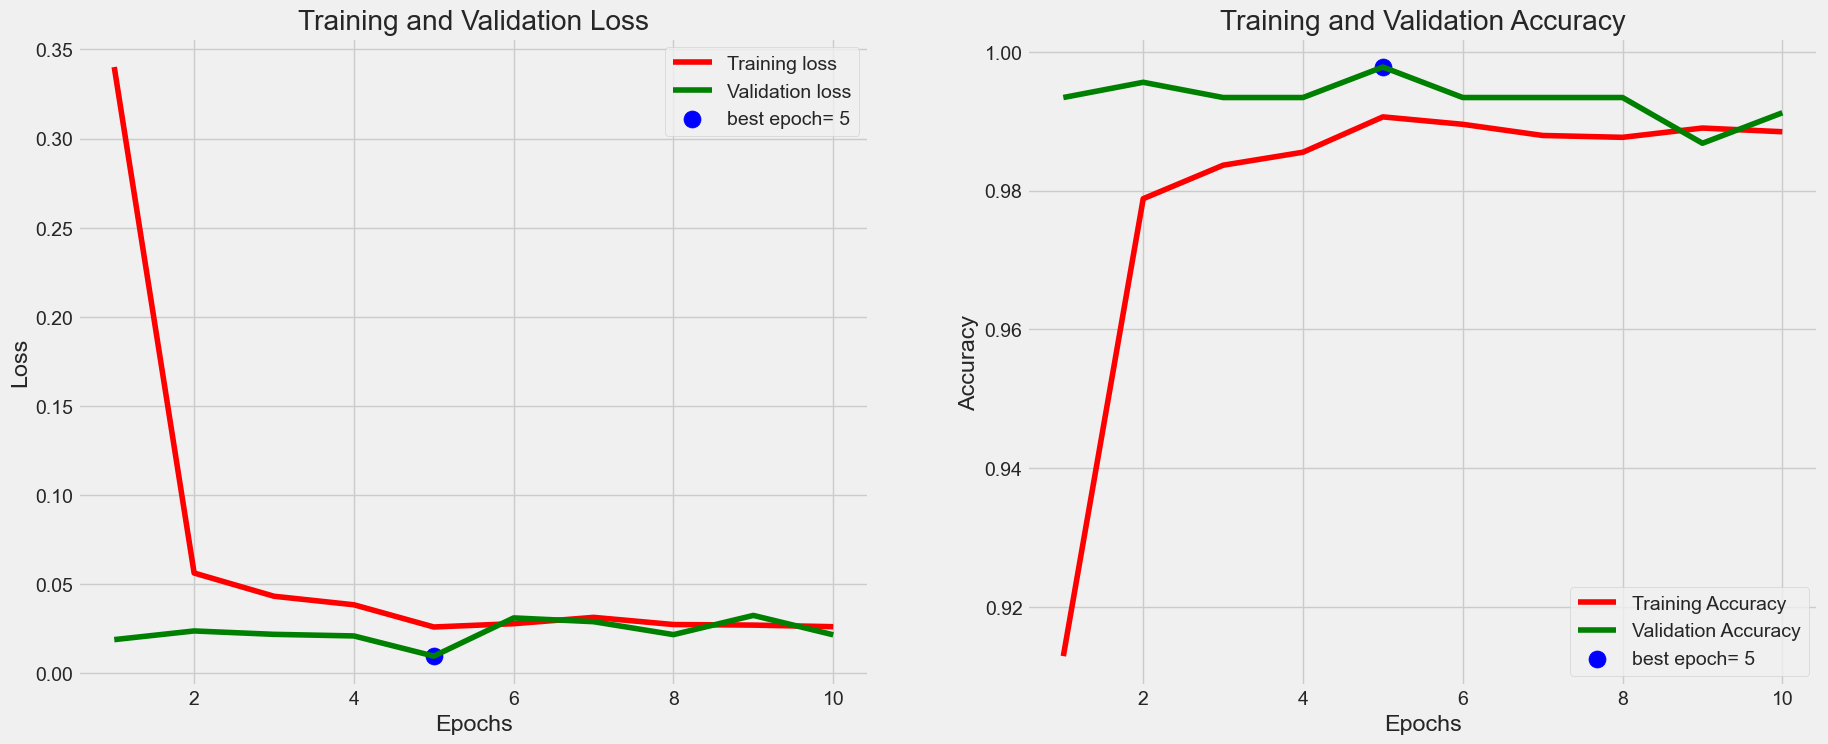

229/229 [==============================] - 116s 505ms/step - loss: 0.0143 - accuracy: 0.9978
accuracy on the test set is 99.78 %



C:\Users\WinX\AppData\Local\Temp\ipykernel_4088\2158545311.py:24: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, save_loc)


229/229 [==============================] - 114s 497ms/step


In [46]:
# tr_plot(history,0)
# save_dir=r'./'
# subject='Jenis Kopi'
# acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
# msg=f'accuracy on the test set is {acc:5.2f} %'
# print_in_color(msg, (0,255,0),(55,65,80))
# save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
# save_loc=os.path.join(save_dir, save_id)
# model.save(save_loc)

from tensorflow.keras.models import save_model
import numpy as np
tr_plot(history, 0)

save_dir = './'
subject = 'Jenis Kopi'
acc = model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1] * 100
msg = f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0, 255, 0), (55, 65, 80))
save_id = str(model_name + '-' + subject + '-' + str(acc)[:str(acc).rfind('.') + 3] + '.h5')
save_loc = os.path.join(save_dir, save_id)

# Simpan model
save_model(model, save_loc)

# Prediksi menggunakan model
predictions = model.predict(test_gen)

# Simpan prediksi ke file
np.save("predictions.npy", predictions)


In [50]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# TES MODEL

# Load dan preproses gambar
img_path = "D:/manda/coffee/Robusta/bean/coba1.png"

img = image.load_img(img_path, target_size=(height, width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Lakukan prediksi pada data uji
predictions = model.predict(img_array)

# Interpretasi hasil prediksi
class_index = np.argmax(predictions)
class_labels = ['arabika', 'robusta']

class_label = class_labels[class_index]
print("Predicted class:", class_label)
print("Predicted probabilities:", predictions)

1/1 [==============================] - 0s 145ms/step
Predicted class: robusta
Predicted probabilities: [[0. 1.]]


In [51]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# TES MODEL

# Load dan preproses gambar
img_path = "D:/manda/coffee/Robusta/bean/coba2robusta.jpg"

img = image.load_img(img_path, target_size=(height, width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Lakukan prediksi pada data uji
predictions = model.predict(img_array)

# Interpretasi hasil prediksi
class_index = np.argmax(predictions)
class_labels = ['arabika', 'robusta']

class_label = class_labels[class_index]
print("Predicted class:", class_label)
print("Predicted probabilities:", predictions)

1/1 [==============================] - 0s 146ms/step
Predicted class: robusta
Predicted probabilities: [[0.00236235 0.9976376 ]]


In [52]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# TES MODEL

# Load dan preproses gambar
img_path = "D:/manda/coffee/Robusta/leaf/cobadaunR1.jpg"

img = image.load_img(img_path, target_size=(height, width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Lakukan prediksi pada data uji
predictions = model.predict(img_array)

# Interpretasi hasil prediksi
class_index = np.argmax(predictions)
class_labels = ['arabika', 'robusta']

class_label = class_labels[class_index]
print("Predicted class:", class_label)
print("Predicted probabilities:", predictions)

1/1 [==============================] - 0s 144ms/step
Predicted class: robusta
Predicted probabilities: [[7.3500581e-05 9.9992645e-01]]


In [55]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# TES MODEL

# Load dan preproses gambar
img_path = "D:/manda/coffee/arabika/bean/cobaA1.png"

img = image.load_img(img_path, target_size=(height, width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Lakukan prediksi pada data uji
predictions = model.predict(img_array)

# Interpretasi hasil prediksi
class_index = np.argmax(predictions)
class_labels = ['arabika', 'robusta']

class_label = class_labels[class_index]
print("Predicted class:", class_label)
print("Predicted probabilities:", predictions)

1/1 [==============================] - 0s 163ms/step
Predicted class: arabika
Predicted probabilities: [[1.0000000e+00 1.3352981e-14]]


In [57]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# TES MODEL

# Load dan preproses gambar
img_path = "D:/manda/Data Sekunder/hasil_seleksi/arabika/daun/cobaA.png"

img = image.load_img(img_path, target_size=(height, width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Lakukan prediksi pada data uji
predictions = model.predict(img_array)

# Interpretasi hasil prediksi
class_index = np.argmax(predictions)
class_labels = ['arabika', 'robusta']

class_label = class_labels[class_index]
print("Predicted class:", class_label)
print("Predicted probabilities:", predictions)

1/1 [==============================] - 0s 148ms/step
Predicted class: arabika
Predicted probabilities: [[0.59782344 0.40217656]]
